Hello all talented Data Scientists. I am excited to share my first piece of art and my thoughts on kaggling through the Titanic Dataset. I have spent a while working thorough several approaches but have settled with this simple approach which gave me a satisfactory result. Hope you all will have a good read.

In [1]:

suppressPackageStartupMessages(library (caret))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(MLmetrics))
suppressPackageStartupMessages(require(caretEnsemble))
suppressPackageStartupMessages(require(e1071))
suppressPackageStartupMessages(require(dummies))
suppressPackageStartupMessages(require(stringr))

#Loading Test and Train Data
test<-read.csv("../input/titanic/test.csv", na.strings = c("","NA"))
train<-read.csv("../input/titanic/train.csv",na.strings = c("","NA"))

The Titanic disaster was a moment of crisis, which means in my opinion there will be a lot of noise in the data. In other words it will not be easy to predict survival at a crisis event due to a large number of uncertainties we are unaware of and many decision made by rescuers at the spot. Since I have taken up this venture to predict anyway, I will make my best guesses. As shown in the Titanic movie, the goal was to save children and women first. So if we check the test data for survival of women, we know it is going to be high. As shown below, we can see 233 women survived while only 109 men survived.

In [2]:
table(train$Sex,train$Survived)

        
           0   1
  female  81 233
  male   468 109

Let's check the dimension of train data.

In [3]:
dim(train)

[1] 891  12

We notice it is a small dataset, which has only 11 features excluding our target variable. I want to check the structure of train data to understand the given data and making some strategies on how we can perform some feature engineering.

In [4]:
str(train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  NA "C85" NA "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


We have PassnegerID, which is important for output but won't affect our prediction. We can instantly notice Sex and Age and hopefully those two will be the most impactful features based on our assumption. Name is not important in itself, since it just identifies each person (as good as ID). But I can extract some useful information from name. For example the title (Mr./Mrs./Dr.) should have some importance. This would identify the gender, approximate age (Mr. shall be an elderly man than Master) and their socio-economic status (Dr. and Mr. might have an impact). I also want to add some features combining age and sex down the line.

With that plan in mind, I check the NAs.

In [5]:
colSums(is.na(train))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0         687           2

In [6]:
colSums(is.na(test))

PassengerId      Pclass        Name         Sex         Age       SibSp 
          0           0           0           0          86           0 
      Parch      Ticket        Fare       Cabin    Embarked 
          0           0           1         327           0

I plan to fill all Age NAs with their median. All Cabin NA's by the mode. Also the one missing Fare value can be filled in with the median. 
Skewness will affect our prediction models. We will also check the skewness of the numeric data we are working with.

In [7]:
sapply(select_if(train, is.numeric), skewness)

PassengerId    Survived      Pclass         Age       SibSp       Parch 
  0.0000000   0.4769135  -0.6284264          NA   3.6829188   2.7398677 
       Fare 
  4.7712097

Looking at the skewness of our most skewed data.

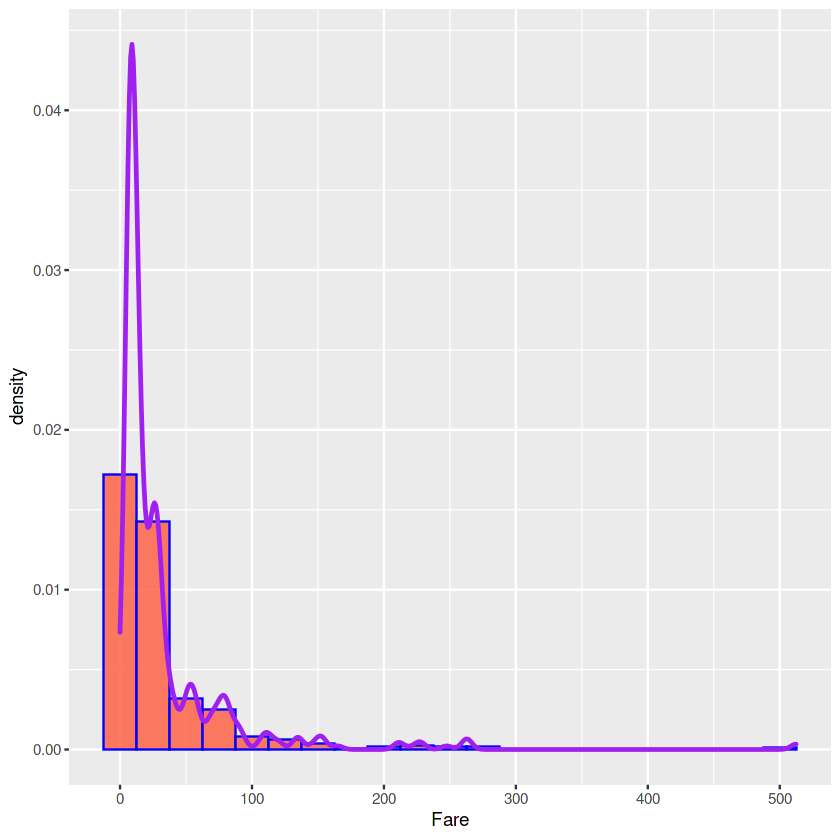

In [8]:
g = ggplot(data=train, aes(x = Fare))
g = g + geom_histogram(aes(y=..density..),binwidth=25, col="blue", fill="tomato", alpha = 0.85)
g = g + geom_density(lwd=1 , col = "purple")
g


We do have some skewness in our data but they did not seem dramatically high. I will perform a square root transformation for skewness > 1.

This made me ready to perform my first round of feature engineering. I used a function to perform my feature engineering and applied both test and train data through the function.

In [9]:
#Dataset Modifications
processthis<-function(dataset) {


  #Adding M-type which is abberviation of Marital Type
  dataset$Mtype <- str_extract(string = dataset$Name,pattern = "(Mr|Master|Mrs|Miss|Rev|Dr|Ms|Col)\\.")
  relevant.Mtype <- c("Mr.", "Mrs.", "Miss.", "Master.", "Rev.", "Dr.", "Ms." , "Col.")
  dataset$Mtype[!(dataset$Mtype %in% relevant.Mtype)] <- "Unknown"
  dataset$Mtype[dataset$Mtype == 'Ms.'] <- "Miss."
  dataset$LastName<-gsub(",.*$", "", dataset$Name)
  rm(relevant.Mtype)

  #Test Dataset Cleanup
  dataset$Age[is.na(dataset$Age)] = median(dataset$Age, na.rm = TRUE)
  dataset$Fare[is.na(dataset$Fare)] = median(dataset$Fare, na.rm = TRUE)

  #Adding Features
  dataset$Marital.Status <- ifelse(dataset$Mtype%in% c("Mr.", "Mrs."),"Married",
                                   ifelse(dataset$Mtype%in% c("Miss.", "Master."),
                                          "Not-Married","Unknown"))
  dataset$Age.Group <- ifelse(dataset$Age<=10,"Child",
                              ifelse(dataset$Age>=10 & dataset$Age<20,
                                     "Teen",
                                     ifelse(dataset$Age>=20 & dataset$Age<40,
                                            "Young",
                                            ifelse(dataset$Age>=40 & dataset$Age<60,
                                                   "MiddleAge",
                                                   "Old"))))
  dataset$AgeBySex <- paste(dataset$Sex , dataset$Age.Group, sep="_")

  #Indicate if cabin information was available or not
  dataset$Cabin[is.na(dataset$Cabin)!=TRUE] <- 'Y'
  dataset$Cabin[is.na(dataset$Cabin)==TRUE] <- 'X'
    
  #Imputing Embarked by Mode
  dataset$Embarked[is.na(dataset$Embarked)==TRUE] <- 'S'

  #Removing Skew
  dataset$SqFare <- (sqrt(dataset$Fare))
  dataset$Fare <- NULL
  dataset$SibSp <- (sqrt(dataset$SibSp))
  dataset$Parch <- (sqrt(dataset$Parch))

  #Removing Irrelevant Data
  dataset <- dataset %>% select(-c("Name","Ticket","Parch"))

  return(dataset)

}

train <- processthis(train)
test <- processthis(test)

Now let's perform some exploratory analysis and take a deeper look at our data and features. We will start with the newly created AgeBySex feature. We look into a bar plot to see how our data is distrubuted among the AgeBySex feature.

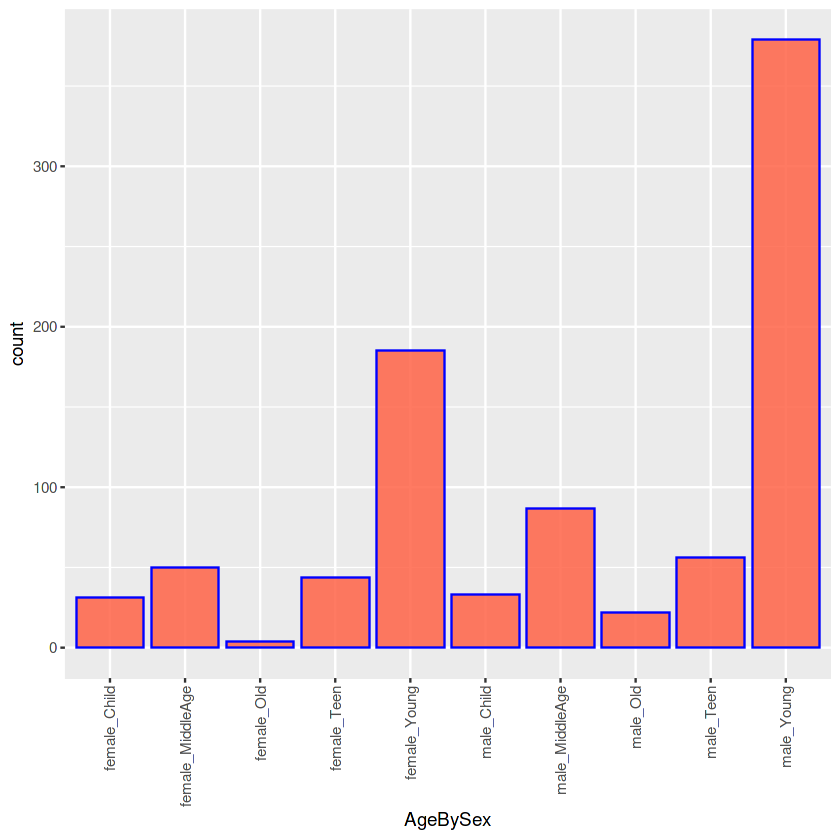

In [10]:
g = ggplot(data=train, aes(x = AgeBySex))
g = g + geom_bar(col="blue",fill="tomato", alpha=0.85)
g = g +theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
g

I am a huge fan of violin plots on this data. This gives a good indication of survival proportions for each category. For example, the plot below indicates bigger portion of the males fall in the category of Survived = 0 and bigger portion of the females fall in the category Survived = 1.

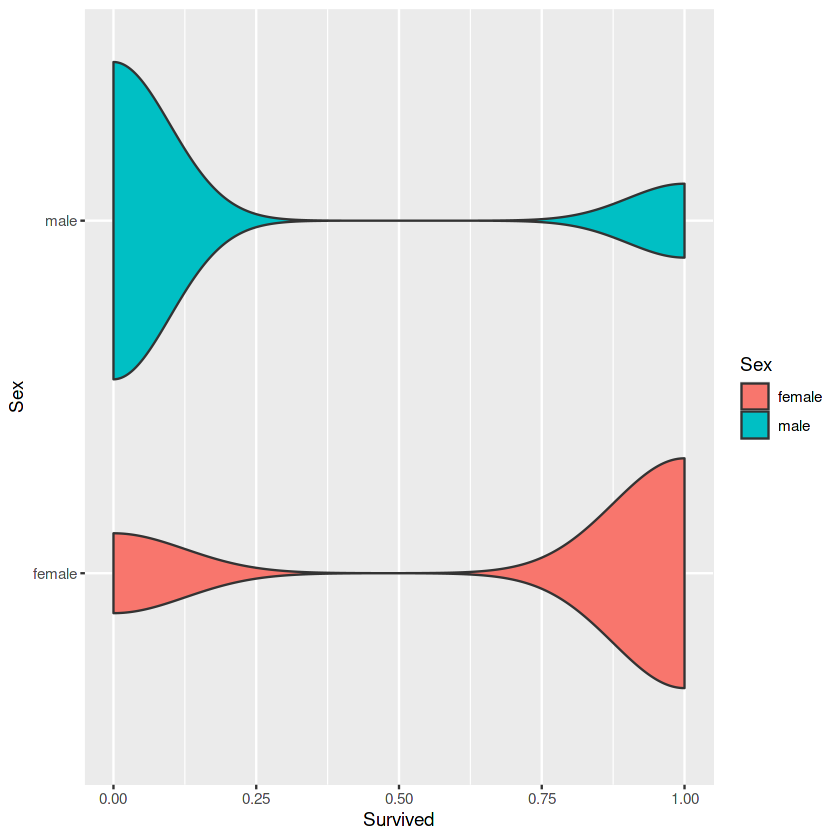

In [11]:
g = ggplot(data=train, aes(x = Survived, y = Sex,fill = Sex))
g = g + geom_violin()
g

Let's look at the AgeBySex feature to find out survival rates.

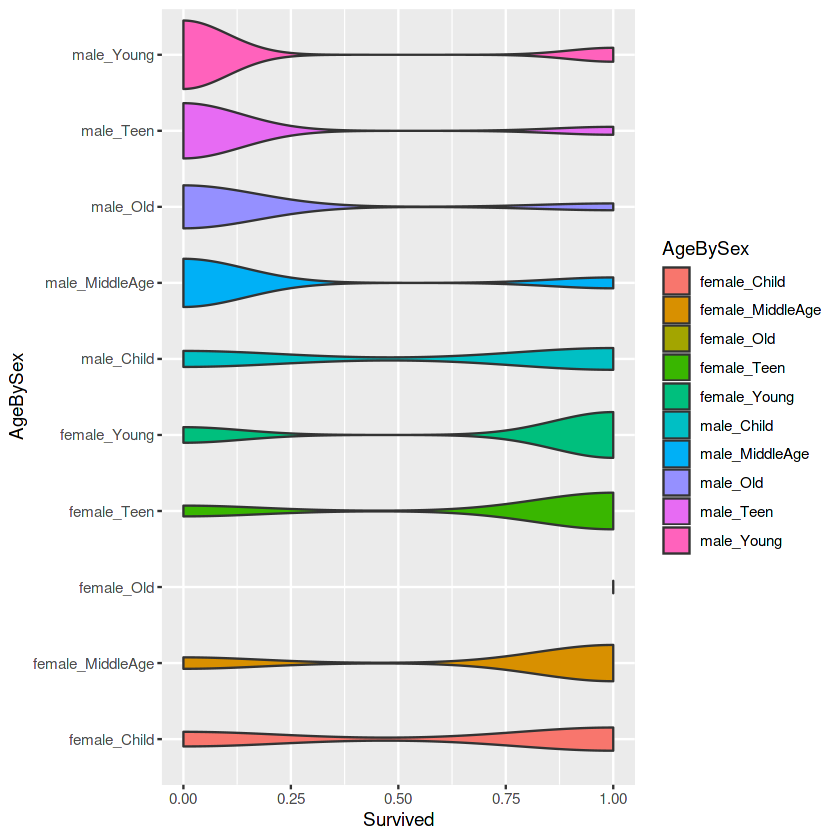

In [12]:
g = ggplot(data=train, aes(x = Survived, y = AgeBySex,fill = AgeBySex))
g = g + geom_violin()
g

As it can be seen young males mostly perished in the event while young and teen females made it through. Female and male children survival was almost 50-50 while the attempt was to save most of the children. It can possibly be because of the young age it was hard to withstand the cold of the Atlantic leading to their unfortunate demise.

Let's look at our next new feature, MType.

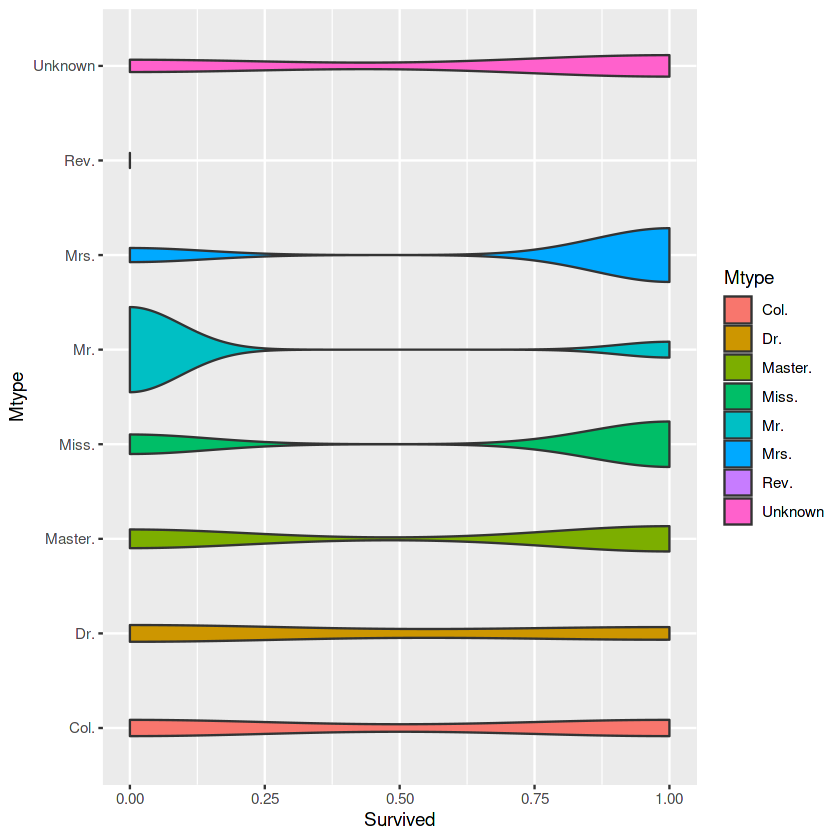

In [13]:
g = ggplot(data=train, aes(x = Survived, y = Mtype,fill = Mtype))
g = g + geom_violin()
g

While this is not extremely helpful in indicating much new information besides chances of female survival was higher than male survival, this refines our assumptions a little more which should help tree based models & find a lower entropy more effectively. For example, chances of survival of a "Mr." would be much lesser than the chances of a "Master" though both indicates Sex: male.

However the surprising result was, unmarried people were more likely to survive than married people. This might be related to age but this new feature should bring some new information useful for our models in my opinion.

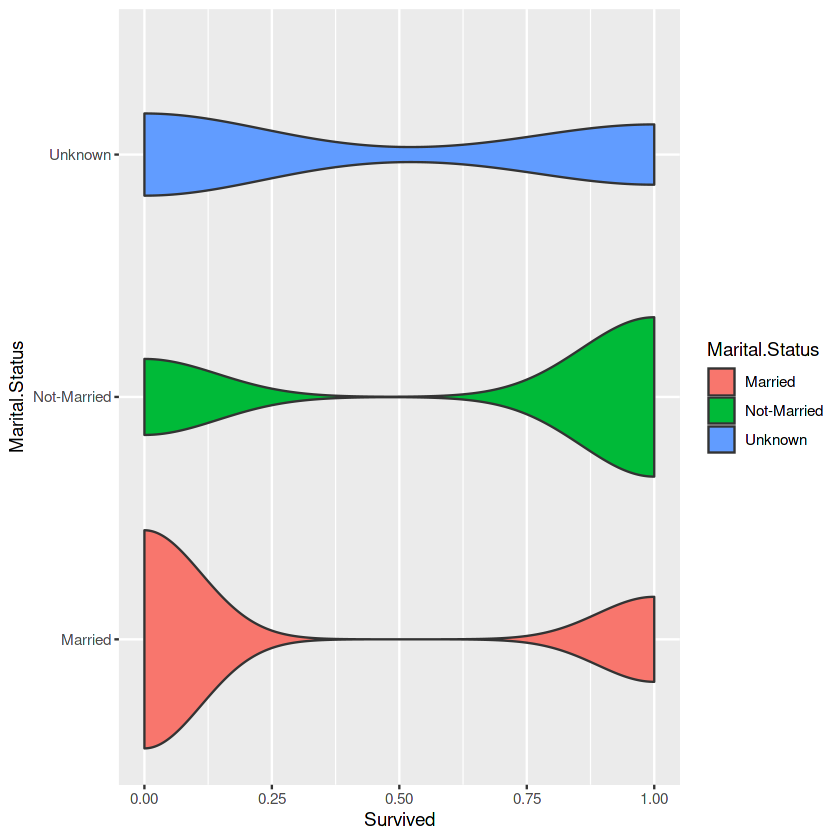

In [14]:
g = ggplot(data=train, aes(x = Survived, y = Marital.Status,fill = Marital.Status))
g = g + geom_violin()
g

Let's take another look at the skewness of Fare after sqrt transformation.

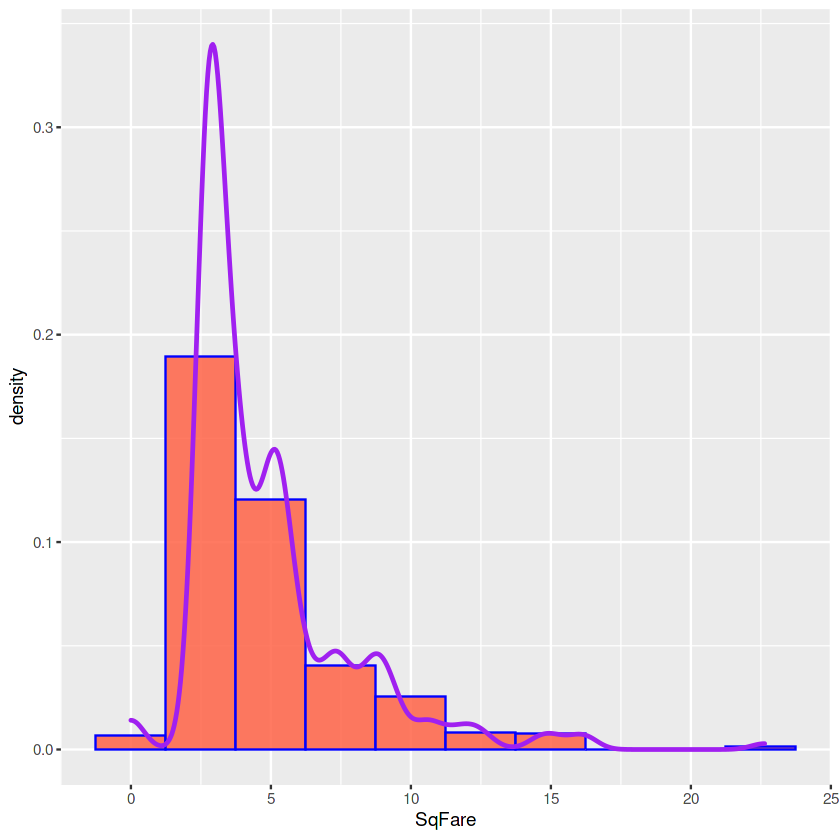

In [15]:
g = ggplot(data=train, aes(x = SqFare))
g = g + geom_histogram(aes(y=..density..),binwidth=2.5, col="blue", fill="tomato", alpha = 0.85)
g = g + geom_density(lwd=1 , col = "purple")
g

With the exploratory analysis, let's proceed towards training our model.

I will create dummies for the categorical features. I felt some features would work best as factors so they were changed to factors.

In [16]:
#Dummies
options(warn = -1)
test$Survived <-0
bigset<-rbind(train,test)
bigset<- dummy.data.frame(bigset, dummy.classes = "character")

#Converting to Friendly Factors
bigset$Survived <- as.factor(make.names(bigset$Survived))
bigset$Pclass <- as.factor(make.names(bigset$Pclass))
bigset$SibSp <- as.factor(make.names(bigset$SibSp))
colnames(bigset) <- make.names(colnames(bigset))
train<- bigset[1:nrow(train),]; test<- bigset[(nrow(train)+1):nrow(bigset),]
test$Survived <-NULL; rm(bigset)

In [17]:
dim(train)

[1] 891 914

Separating the dataset into train into trainset and validation data.

In [18]:
#Separating into trainset & val
set.seed(122)
trainID <- createDataPartition(train$Survived, p=0.7, list = FALSE)
trainset <- train[trainID,] ; val <- train[-trainID,]

Tree based algos seemed to be more efficient for this data. I would have guessed the same for this kind of classification problem since, as mentioend below, the noise will be too high due to the kind of prediction.

In [19]:
#RandomForest
now <- Sys.time()
myControl <- trainControl(method = "repeatedcv", number = 5, repeats = 5,
                          classProbs = TRUE)
grids <- expand.grid(mtry = 25,
                     splitrule = "extratrees",
                     min.node.size = 10)
modFitRF <- train(Survived~.-PassengerId, data=trainset, method = "ranger",
                  tuneGrid = grids,
                  trControl = myControl, metric = "Accuracy",
                  importance = "permutation")
elapsed <- Sys.time() - now ; elapsed
confusionMatrix(predict(modFitRF,val), val$Survived)
round(F1_Score(predict(modFitRF,val), val$Survived, NULL),3)

Time difference of 2.434081 mins

Confusion Matrix and Statistics

          Reference
Prediction  X0  X1
        X0 134  24
        X1  30  78
                                          
               Accuracy : 0.797           
                 95% CI : (0.7436, 0.8437)
    No Information Rate : 0.6165          
    P-Value [Acc > NIR] : 1.928e-10       
                                          
                  Kappa : 0.5754          
                                          
 Mcnemar's Test P-Value : 0.4962          
                                          
            Sensitivity : 0.8171          
            Specificity : 0.7647          
         Pos Pred Value : 0.8481          
         Neg Pred Value : 0.7222          
             Prevalence : 0.6165          
         Detection Rate : 0.5038          
   Detection Prevalence : 0.5940          
      Balanced Accuracy : 0.7909          
                                          
       'Positive' Class : X0              
                              

[1] 0.832

Let's check how the feature engineering worked out.

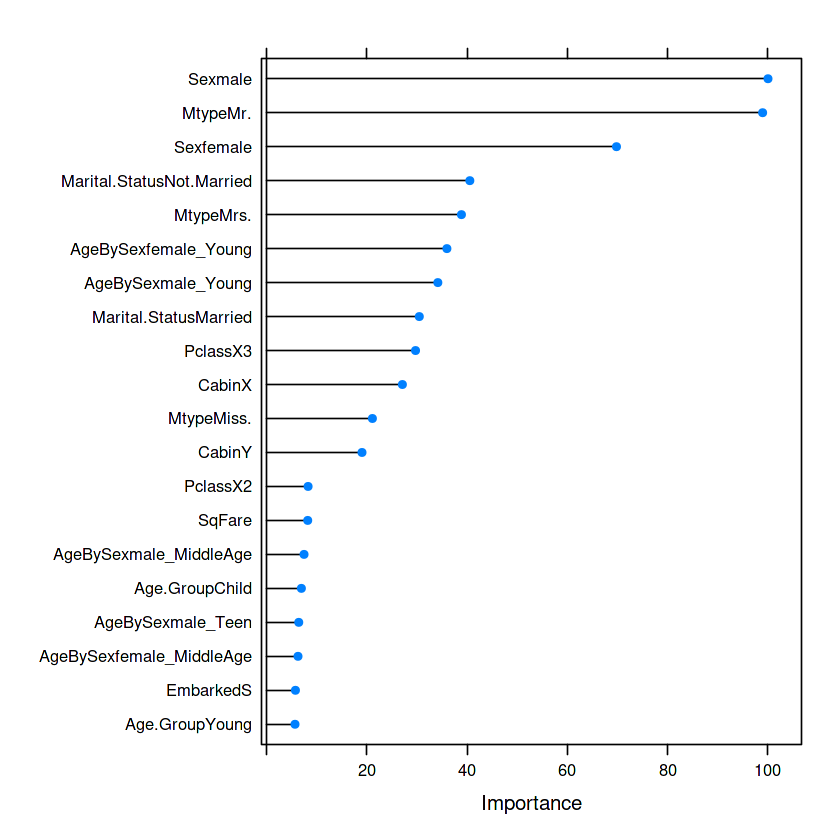

In [20]:
plot(varImp(modFitRF),20)

As expected Sex is quite up in the list. Looking at the importances the new features like Mtype, AgeBySex are playing an important role in our prediction.

Confusion Matrix and Statistics

          Reference
Prediction  X0  X1
        X0 141  28
        X1  23  74
                                          
               Accuracy : 0.8083          
                 95% CI : (0.7557, 0.8538)
    No Information Rate : 0.6165          
    P-Value [Acc > NIR] : 1.164e-11       
                                          
                  Kappa : 0.5907          
                                          
 Mcnemar's Test P-Value : 0.5754          
                                          
            Sensitivity : 0.8598          
            Specificity : 0.7255          
         Pos Pred Value : 0.8343          
         Neg Pred Value : 0.7629          
             Prevalence : 0.6165          
         Detection Rate : 0.5301          
   Detection Prevalence : 0.6353          
      Balanced Accuracy : 0.7926          
                                          
       'Positive' Class : X0              
                              

[1] 0.847

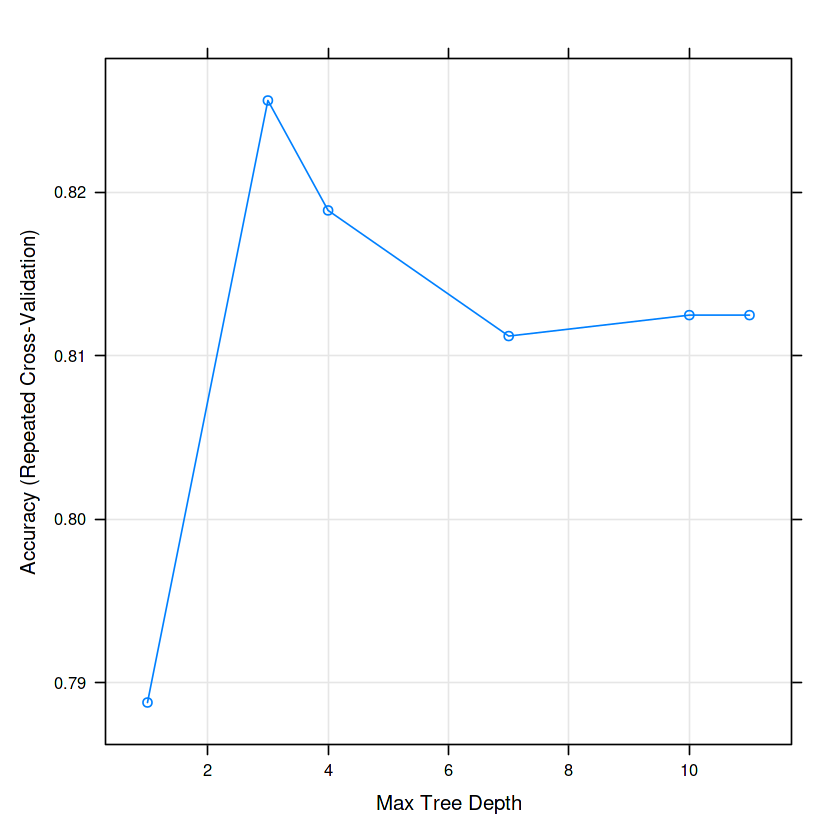

In [21]:
#Rpart
myControl <- trainControl(method = "repeatedcv", number = 5, repeats = 5)
modFitRpart <- train(Survived~.-PassengerId, data=trainset, method = "rpart2",
                     tuneLength = 6, trControl = myControl, metric = "Accuracy")
plot(modFitRpart)
confusionMatrix(predict(modFitRpart,val), val$Survived)
round(F1_Score(predict(modFitRpart,val), val$Survived, NULL),3)

Looks like a tree depth of 3 would be a good choice for decision tree algorithm.

I also found generalized linear model with penalized likelihood (glmnet) to be quite useful. We use alpha = 0.1 which is more like a ridge regression.

In [22]:
#glmNet
myControl <- trainControl(method = "repeatedcv", number = 5, repeats = 5,
                          classProbs = TRUE)
modFitglmNet <- train(Survived~.-PassengerId, data=trainset, method = "glmnet",
                     tuneGrid = expand.grid(alpha = 0.1,
                                            lambda = 0.015),
                     trControl = myControl, metric = "Accuracy")
confusionMatrix(predict(modFitglmNet,val, s="lambda.min"), val$Survived)
round(F1_Score(predict(modFitglmNet,val), val$Survived, NULL),3)

Confusion Matrix and Statistics

          Reference
Prediction  X0  X1
        X0 138  24
        X1  26  78
                                          
               Accuracy : 0.812           
                 95% CI : (0.7598, 0.8571)
    No Information Rate : 0.6165          
    P-Value [Acc > NIR] : 4.357e-12       
                                          
                  Kappa : 0.6039          
                                          
 Mcnemar's Test P-Value : 0.8875          
                                          
            Sensitivity : 0.8415          
            Specificity : 0.7647          
         Pos Pred Value : 0.8519          
         Neg Pred Value : 0.7500          
             Prevalence : 0.6165          
         Detection Rate : 0.5188          
   Detection Prevalence : 0.6090          
      Balanced Accuracy : 0.8031          
                                          
       'Positive' Class : X0              
                              

[1] 0.847

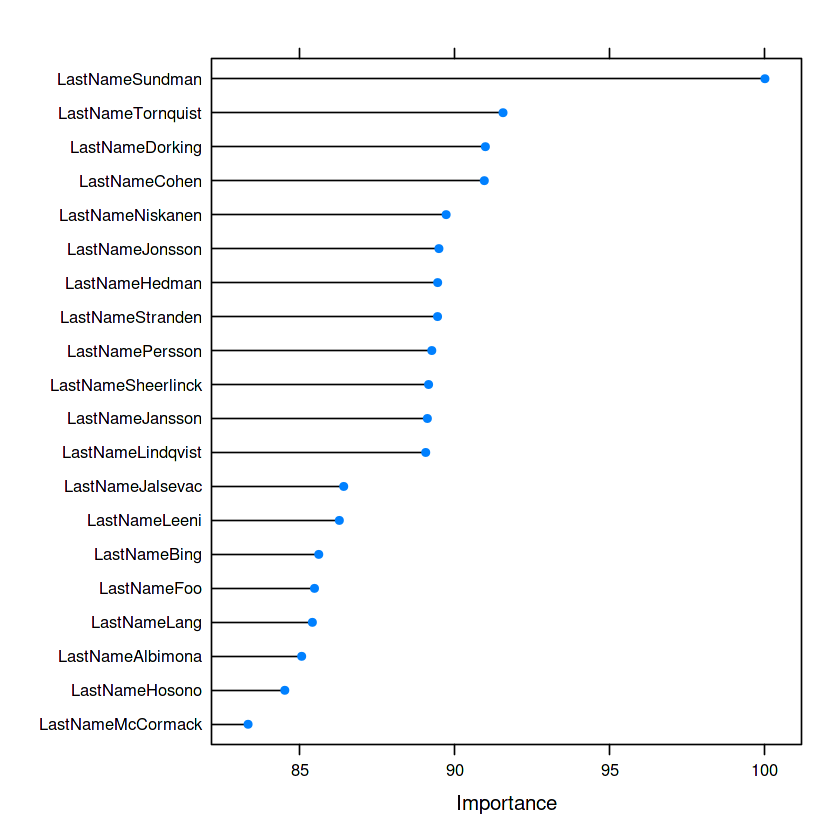

In [23]:
plot(varImp(modFitglmNet,),20)

Feature Last Name proves to be extremely useful for Ridge model.

Both decision tree and glmnet gave us desirable results. We create an average of Random Forest and GlmNet to optimize the prediction.

In [24]:
# Check with Combination of RF and glmNet
predRF <- predict(modFitRF,val, type='prob')$X1
predglmNet <- predict(modFitglmNet,val, type='prob')$X1
pred = (predRF + predglmNet)/2
pred <- ifelse(pred>=0.5,"X1","X0")
round(F1_Score(pred, val$Survived, NULL),3)

[1] 0.857

We have a improvement of F1 score from 0.847 to 0.857. I chose this model to make my predicitons.

In [25]:
#RandomForest
myControl <- trainControl(method = "repeatedcv", number = 5, repeats = 5,
                          classProbs = TRUE)
modFitRF <- train(Survived~.-PassengerId, data=train, method = "ranger",
                  tuneGrid = expand.grid(mtry = 25,
                                         splitrule = "extratrees",
                                         min.node.size = 10),
                  trControl = myControl, metric = "Accuracy")

#glmNet
myControl <- trainControl(method = "repeatedcv", number = 5, repeats = 5,
                          classProbs = TRUE)
modFitRidge <- train(Survived~.-PassengerId, data=train, method = "glmnet",
                     tuneGrid = expand.grid(alpha = 0.1,
                                            lambda = 0.015),
                     trControl = myControl, metric = "Accuracy")

#Average
pred1 <- predict(modFitRF,test, type='prob')$X1
pred2 <- predict(modFitRidge,test, type='prob')$X1
pred = (pred1 + pred2)/2
pred <- ifelse(pred>=0.5,1,0)

#Creating Prediction File
prediction <- data.frame(PassengerId = test$PassengerId , Survived = pred)
write.csv(prediction,"submission.csv", row.names = FALSE)
